In [1]:
# https://www.kaggle.com/virajbagal/fast-ai-mixup-cutmix-augmix-and-gridmask-visuals
# https://www.kaggle.com/ipythonx/keras-grapheme-gridmask-augmix-ensemble

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
from keras.utils import Sequence
from pathlib import Path
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import albumentations
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform
from albumentations.augmentations import functional as F

C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\

In [3]:
train_df_ = pd.read_csv('bengaliai-cv19/train.csv')


In [4]:
# print(class_map_df.head())
# class_map_df['component_type'].value_counts()

In [5]:
IMG_SIZE=64
SEED = 999
N_CHANNELS = 1
im_path = 'bengaliai-cv19/'
stats = (0.0692, 0.2051)
datadir = Path('bengaliai-cv19/')
featherdir = Path('bengaliai-cv19/bengaliaicv19feather')
outdir = Path('.')

HEIGHT = 137
WIDTH = 236


In [6]:
# def prepare_image(datadir, featherdir, data_type='train',
#                   submission=False, indices=[0, 1, 2, 3]):
#     assert data_type in ['train', 'test']
#     if submission:
#         image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
#                          for i in indices]
#     else:
#         image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
#                          for i in indices]

#     print('image_df_list', len(image_df_list))
#     HEIGHT = 137
#     WIDTH = 236
#     images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
#     del image_df_list
#     gc.collect()
#     images = np.concatenate(images, axis=0)
#     return images

# # train = pd.read_csv(datadir/'train.csv')
# # train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# indices = [0, 1, 2, 3]
# train_images = prepare_image(
#     datadir, featherdir, data_type='train', submission=False, indices=indices)


[[252 252 253 ... 253 254 253]
 [254 254 254 ... 255 255 253]
 [255 254 254 ... 255 255 252]
 ...
 [255 255 255 ... 255 255 254]
 [255 255 255 ... 255 255 254]
 [255 255 255 ... 255 255 254]]
[[0.67583317 0.67583317 0.6770095  ... 0.99319225 0.99457292 0.99339654]
 [0.68119695 0.68119695 0.68119695 ... 0.99999998 0.99999998 0.99360089]
 [0.6838788  0.68119695 0.68119695 ... 0.99999998 0.99999998 0.99195435]
 ...
 [0.29996288 0.29996288 0.29996288 ... 0.99999998 0.99999998 0.99882372]
 [0.29996288 0.29996288 0.29996288 ... 0.99999998 0.99999998 0.99882372]
 [0.29996288 0.29996288 0.29996288 ... 0.73599164 0.73599164 0.73585064]]


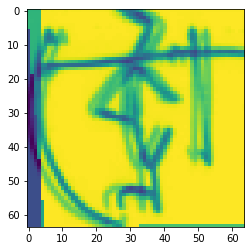

[[255 255 255 ... 119 125 198]
 [255 255 255 ...  55  58 112]
 [255 255 255 ...  72  73  99]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[0.70463107 0.70463107 0.70463107 ... 0.51561642 0.51609751 0.71803387]
 [0.70463107 0.70463107 0.70463107 ... 0.27912498 0.28209665 0.42105481]
 [0.70463107 0.70463107 0.70414231 ... 0.35169586 0.35586531 0.42080749]
 ...
 [0.70463107 0.70463107 0.70463107 ... 0.85019471 0.85019471 0.85019471]
 [0.69974323 0.69045628 0.68068052 ... 0.85019471 0.85019471 0.85019471]
 [0.5799904  0.5799904  0.5799904  ... 0.85019471 0.85019471 0.85019471]]


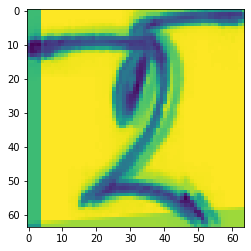

[[253 254 254 ... 253 251 251]
 [254 255 254 ... 254 253 252]
 [254 253 251 ... 254 253 252]
 ...
 [184 127 101 ...  69 112 190]
 [239 223 187 ...  76 108 190]
 [248 249 239 ... 121 160 217]]
[[0.90729812 0.91063198 0.91088429 ... 0.90704582 0.90012581 0.90012581]
 [0.91088429 0.91421814 0.91088429 ... 0.91063198 0.90729812 0.90371196]
 [0.91088429 0.90729812 0.90012581 ... 0.91063198 0.90729812 0.90371196]
 ...
 [0.69465109 0.4999548  0.40740951 ... 0.28355953 0.41431742 0.70039137]
 [0.87301129 0.81164901 0.68041087 ... 0.31205361 0.40398055 0.69886507]
 [0.89477384 0.87973553 0.82915256 ... 0.4764281  0.5953352  0.80342718]]


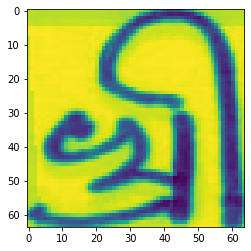

[[249 252 250 ... 252 249 248]
 [247 249 247 ... 253 250 249]
 [249 247 242 ... 253 251 250]
 ...
 [249 249 252 ... 253 254 254]
 [249 249 252 ... 253 254 254]
 [251 249 251 ... 253 254 254]]
[[0.70315164 0.70389409 0.70597559 ... 0.17126217 0.20123426 0.20098678]
 [0.69235102 0.69026958 0.69750388 ... 0.18826303 0.18752059 0.17610419]
 [0.67223464 0.65628115 0.65246729 ... 0.16685593 0.17101469 0.17635167]
 ...
 [0.71345737 0.71603377 0.71419981 ... 0.20222418 0.24900886 0.29554603]
 [0.71345737 0.71603377 0.71419981 ... 0.22176981 0.27693116 0.29554603]
 [0.71395233 0.71345737 0.71137593 ... 0.22176981 0.27693116 0.29554603]]


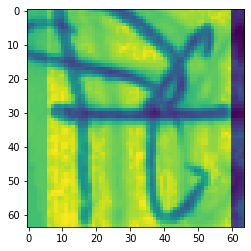

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[0.55009859 0.55009859 0.55009859 ... 0.54513257 0.53023453 0.50354219]
 [0.55009859 0.55009859 0.55009859 ... 0.51347422 0.46878009 0.45077828]
 [0.55009859 0.55009859 0.55009859 ... 0.46133106 0.43836324 0.47250459]
 ...
 [0.55009859 0.55009859 0.55009859 ... 0.39180684 0.39180684 0.39180684]
 [0.55009859 0.55009859 0.55009859 ... 0.39180684 0.39180684 0.39180684]
 [0.55009859 0.55009859 0.55009859 ... 0.39180684 0.39180684 0.39180684]]


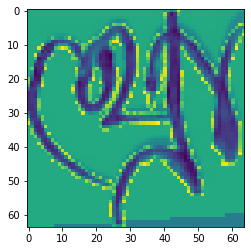

[[249 247 247 ... 253 252 249]
 [251 250 247 ... 249 248 248]
 [250 249 247 ... 244 246 250]
 ...
 [253 252 252 ... 254 254 254]
 [253 252 252 ... 254 254 254]
 [252 251 252 ... 255 255 255]]
[[0.772935   0.72947384 0.72947384 ... 0.94218494 0.88129298 0.7638693 ]
 [0.84562607 0.80516239 0.72947384 ... 0.73283693 0.70070606 0.72267285]
 [0.80516239 0.772935   0.72947384 ... 0.63370769 0.65036785 0.7591368 ]
 ...
 [0.95648075 0.90221373 0.90221373 ... 0.89654865 0.89654865 0.89654865]
 [0.95613207 0.90186499 0.90221373 ... 0.89654865 0.89654865 0.89654865]
 [0.90221373 0.84597475 0.90221373 ... 0.89722554 0.89722554 0.89722554]]


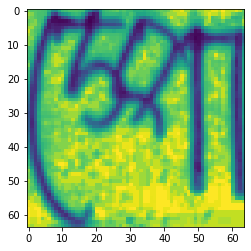

[[253 253 252 ... 250 250 252]
 [253 251 250 ... 251 251 251]
 [249 248 249 ... 252 251 250]
 ...
 [248 246 249 ...  80  83 134]
 [251 250 250 ...  97 137 194]
 [252 251 250 ... 162 203 236]]
[[0.99579206 0.99579206 0.98096487 ... 0.92949916 0.92949916 0.98096487]
 [0.99579206 0.95704955 0.92949916 ... 0.95704955 0.95704955 0.95704955]
 [0.90013101 0.86894532 0.90013101 ... 0.98096487 0.95704955 0.92949916]
 ...
 [0.86894532 0.82293238 0.90013101 ... 0.22466266 0.23460977 0.4018928 ]
 [0.95704955 0.92949916 0.92949916 ... 0.28405889 0.41002228 0.57720582]
 [0.98096487 0.95704955 0.92949916 ... 0.48261497 0.60522943 0.72191804]]


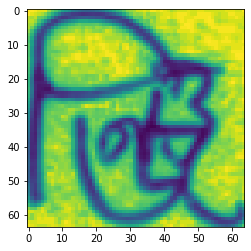

[[252 250 248 ... 254 254 254]
 [252 252 252 ... 254 254 254]
 [252 253 254 ... 254 254 254]
 ...
 [253 253 253 ... 157 212 251]
 [253 252 252 ... 165 221 248]
 [251 250 250 ... 193 238 252]]
[[0.67332595 0.66873206 0.66650974 ... 0.6711549  0.6711549  0.6711549 ]
 [0.67665862 0.67540797 0.67369889 ... 0.6711549  0.6711549  0.6711549 ]
 [0.67369889 0.6763363  0.67772309 ... 0.6711549  0.6711549  0.6711549 ]
 ...
 [0.67730812 0.67730812 0.67730812 ... 0.47226023 0.40914542 0.43861103]
 [0.67541645 0.67684122 0.67684122 ... 0.51226411 0.4070945  0.43095708]
 [0.67448263 0.67590738 0.67756448 ... 0.3314888  0.40877894 0.43282476]]


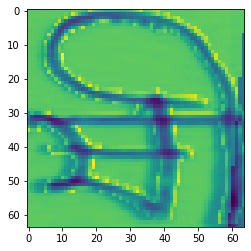

[[253 252 249 ... 253 253 253]
 [252 251 248 ... 252 252 253]
 [253 251 243 ... 251 252 253]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[0.94397842 0.94242971 0.93778364 ... 0.73878379 0.73878379 0.73878379]
 [0.94242971 0.940881   0.93623493 ... 0.73392016 0.72566174 0.7253639 ]
 [0.94316414 0.940881   0.92207958 ... 0.63511716 0.63069008 0.65207049]
 ...
 [0.94789007 0.94789007 0.94789007 ... 0.71665461 0.71665461 0.71665461]
 [0.94789007 0.94789007 0.94789007 ... 0.71665461 0.71665461 0.71665461]
 [0.94789007 0.94789007 0.94789007 ... 0.71665461 0.71665461 0.71665461]]


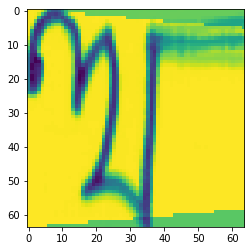

[[254 254 254 ... 255 255 255]
 [255 255 254 ... 255 255 255]
 [255 255 254 ... 255 255 255]
 ...
 [253 254 254 ... 255 255 255]
 [254 254 254 ... 255 255 255]
 [254 254 254 ... 255 255 255]]
[[0.68343629 0.68213684 0.88457328 ... 0.79756361 0.79756361 0.79756361]
 [0.68482752 0.68352807 0.88457328 ... 0.79756361 0.79756361 0.79756361]
 [0.68482752 0.68352807 0.88457328 ... 1.00000002 1.00000002 1.00000002]
 ...
 [0.52186768 0.50023671 0.47006972 ... 1.00000002 0.73778802 0.57015649]
 [0.35337109 0.35337109 0.35337109 ... 0.88856341 0.63414823 0.45871987]
 [0.35337109 0.35337109 0.35337109 ... 0.88856341 0.64194505 0.45612092]]


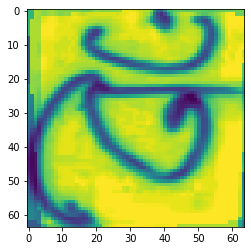

[[243 249 250 ... 248 252 253]
 [248 252 251 ... 253 254 255]
 [253 254 253 ... 253 254 255]
 ...
 [254 254 253 ... 255 255 255]
 [254 254 253 ... 255 255 255]
 [254 254 254 ... 255 255 255]]
[[0.37638996 0.40138464 0.41235769 ... 0.39604519 0.45120467 0.49457102]
 [0.39604519 0.45120467 0.42896437 ... 0.49457102 0.57314749 0.64327352]
 [0.49457102 0.57314749 0.49457102 ... 0.49457102 0.57314749 0.64327352]
 ...
 [0.64912803 0.64912803 0.51922695 ... 0.64327352 0.64327352 0.64327352]
 [0.63403254 0.59780342 0.51922695 ... 0.64327352 0.64327352 0.64327352]
 [0.59780342 0.59780342 0.59780342 ... 0.64327352 0.64327352 0.64327352]]


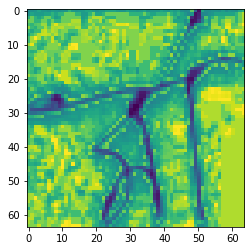

[[254 252 252 ... 252 251 252]
 [254 253 253 ... 253 252 253]
 [252 253 254 ... 254 254 254]
 ...
 [253 253 253 ... 254 254 254]
 [253 253 253 ... 255 255 255]
 [253 253 253 ... 255 255 255]]
[[0.84888511 0.84221938 0.84221938 ... 0.84221938 0.83888652 0.84221938]
 [0.84888511 0.98005017 0.98005017 ... 0.98005017 0.97671731 0.98005017]
 [0.84221938 0.98005017 0.98338303 ... 0.98338303 0.98338303 0.98338303]
 ...
 [0.84321423 0.97771216 0.97771216 ... 0.98104503 0.98104503 0.98104503]
 [0.84321423 0.97771216 0.97771216 ... 0.98437789 0.98437789 0.98437789]
 [0.84321423 0.97771216 0.97771216 ... 0.98437789 0.98437789 0.98437789]]


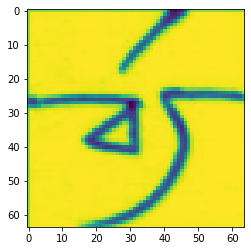

[[253 253 253 ... 253 253 253]
 [254 254 254 ... 253 253 253]
 [254 254 254 ... 253 253 253]
 ...
 [253 253 253 ... 236 242 249]
 [253 254 255 ... 252 252 254]
 [255 255 254 ... 253 253 255]]
[[0.12396727 0.45631731 0.47586729 ... 0.26858001 0.25042645 0.12396727]
 [0.26652867 0.56257156 0.61920931 ... 0.60232648 0.60232648 0.47586729]
 [0.28526337 0.54639554 0.62360675 ... 0.60232648 0.60232648 0.47726374]
 ...
 [0.12396727 0.25042645 0.25042645 ... 0.55496603 0.55400291 0.57555172]
 [0.12396727 0.25794194 0.276386   ... 0.60573954 0.59029211 0.62031956]
 [0.12494725 0.29277887 0.30399805 ... 0.47726374 0.47586729 0.47684727]]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [70]:
# tmp = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1)  
# for i in range(20):
#     img = tmp.loc[i].values.reshape(137,236)
#     img = new_crop_resize(img)#/255
# #     img =  crop_resize(img)/255
# #     img = crop_char_image(img)
# #     img = cv2.resize(img,  (IMG_SIZE,IMG_SIZE))/255
# #     img =  img[:, :, np.newaxis]#img.reshape(64,64,1)
# #     img = affine_image(img)#/255
    
# #     print(img)
# #     img =  img[:, :, np.newaxis]#img.reshape(64,64,1)
#     img = augment_and_mix(img.astype(np.uint8))#/255
# #     print(img)
# #     print(img[:,:,0].shape)
# #     image.reshape(IMG_SIZE,IMG_SIZE,1)
# #     img =  crop_resize(img)
#     plt.imshow(img)
# #     print(img)
#     plt.show()

In [82]:
class GraphemeGenerator(Sequence):
    def __init__(self, data, batch_size, IMG_SIZE, shuffle=True, transform=None):
        self._data = data
        self._label_1 = pd.get_dummies(self._data['grapheme_root'], 
                                       columns = ['grapheme_root'])
        print(self._label_1.shape)
        self._label_2 = pd.get_dummies(self._data['vowel_diacritic'], 
                                       columns = ['vowel_diacritic'])
        self._label_3 = pd.get_dummies(self._data['consonant_diacritic'], 
                                       columns = ['consonant_diacritic'])
        self._list_idx = data.index.values
        
        self._data = self._data.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1)    
        self._data = self.preprocess_resizing()
        
        self._batch_size = batch_size
        self._dim = (IMG_SIZE,IMG_SIZE)
        self._img_size = IMG_SIZE
        self._shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self._data)/self._batch_size))
    
    def preprocess_resizing(self):
        resized = {}
#         print(self._data)
        lst = list(self._data.index)
        for x in tqdm(range(len(lst))):
            img = self._data.loc[lst[x]].values.reshape(137,236)
#             img =  crop_resize(img)
#             img = crop_char_image(img)
#             img = cv2.resize(img,  (IMG_SIZE,IMG_SIZE))/255
            img = new_crop_resize(img)#/255 # 여기서 Scaling 하면 이상한 augmentation이 된다.
            resized[self._data.index[x]] =img.reshape(-1)
        


        
        
        resized =pd.DataFrame(resized).T
        return resized
        
    def __getitem__(self, index):
        batch_idx = self._indices[index*self._batch_size:(index+1)*self._batch_size]
        _idx = [self._list_idx[k] for k in batch_idx]

        Data     = np.empty((self._batch_size, *self._dim, 1))
        Target_1 = np.empty((self._batch_size, 168), dtype = int)
        Target_2 = np.empty((self._batch_size, 11 ), dtype = int)
        Target_3 = np.empty((self._batch_size,  7 ), dtype = int)
        
#         if np.random.rand() > 0.7: print(_idx)
        for i, k in enumerate(_idx):
            # load the image file using cv2

#             image=self._data.loc[k].values.reshape(137,236)
            image=self._data.loc[k].values.reshape(64,64)#,1)# 문제다

#             image = cv2.imread(im_path + self._data['image_id'][k] + '.png')
            
            # Cropping 부분이 속도를 에폭당 40초를 늘린다.
#             image = crop_char_image(image)
#             image = cv2.resize(image,  self._dim) 
            # 에폭당 30초 더걸림
#             image =  crop_resize(image)
#             → 전처리로 다 변경했다.

#             image = image.reshape(self._img_size,self._img_size,1)
        
            if self.transform is not None:
                if np.random.rand() > 0.5:
                    # albumentation : grid mask
#                     res = self.transform(image=image)
#                     image = res['image']
                    # Affine Image
                    image = affine_image(image)
#                     print(image.shape)
#                     plt.imshow(image)
#                     plt.show()
                else :                     
                    image = augment_and_mix(image.astype(np.uint8))
#                     if np.random.rand() > 0.5: 
#                         plt.imshow(image)
#                         plt.show()
#                 else:

                    # augmix augmentation
#                     image = augment_and_mix(image)
            
            # scaling 
#             image = (image.astype(np.float32)/255.0 - stats[0])/stats[1]
            image =  image/255.0
            
            # gray scaling 
#             gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
#             image = gray(image)  
            
#             # expand the axises 
            image = image[:, :, np.newaxis]
#             plt.imshow(image)
#             plt.show()
                    
            
            Data[i,:, :, :] =  image
            Target_1[i,:] = self._label_1.loc[k, :].values
            Target_2[i,:] = self._label_2.loc[k, :].values
            Target_3[i,:] = self._label_3.loc[k, :].values
#             i
#             print(Data.shape, Target_1.shape, Target_2.shape, Target_3.shape)
        return Data, [Target_1, Target_2, Target_3]
    
    
    def on_epoch_end(self):
        self._indices = np.arange(len(self._list_idx))
        if self._shuffle:
            np.random.shuffle(self._indices)

In [79]:
# Image Processing while resizing the images, 
# center crop
def new_crop_resize(image, size=64):
    resized = {}
    resize_size=size
    
    
#     for i in tqdm(range(df.shape[0])):
#         image=df.loc[df.index[i]].values.reshape(137,236)
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = image[ymin:ymax,xmin:xmax]
    image = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
#         resized[df.index[i]] = resized_roi.reshape(-1)

#     resized = pd.DataFrame(resized).T
    return image

In [10]:
# 에폭당 40초 이상 더 걸린다.
def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

In [11]:
# 에폭당 30초 더걸림
# helper function
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=IMG_SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    return cv2.resize(img,(size,size))

In [44]:
# https://www.kaggle.com/haqishen/augmix-based-on-albumentations
from PIL import Image, ImageOps, ImageEnhance
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


In [13]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [14]:
# 이게 느리다.

"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image

In [15]:
# class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

#     def flow(self,
#              x,
#              y=None,
#              batch_size=200,
#              shuffle=True,
#              sample_weight=None,
#              seed=None,
#              save_to_dir=None,
#              save_prefix='',
#              save_format='png',
#              subset=None):

#         targets = None
#         target_lengths = {}
#         ordered_outputs = []
#         for output, target in y.items():
#             if targets is None:
#                 targets = target
#             else:
#                 targets = np.concatenate((targets, target), axis=1)
#             target_lengths[output] = target.shape[1]
#             ordered_outputs.append(output)


#         for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
#                                          shuffle=shuffle):
#             target_dict = {}
#             i = 0
#             for output in ordered_outputs:
#                 target_length = target_lengths[output]
#                 target_dict[output] = flowy[:, i: i + target_length]
#                 i += target_length

#             yield flowx, target_dict

## Data Generation

# Model

In [16]:
from keras_applications.resnext import ResNeXt101
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras_efficientnets import EfficientNetB3
from keras import backend as K
from keras import layers, models, optimizers, utils, backend,regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras import layers, models, optimizers, utils, backend,regularizers
from keras.layers import LeakyReLU
def get_model(model_name='EfficientNetB3'):
#     inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
    pretrained_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(64,64,3))
#     pretrained_model = DenseNet121(include_top= False, input_shape = (64,64,3)
#                             , backend =backend, layers=layers, models = models,
#                              utils = utils
#                             )
    
    
    inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
    model = Conv2D(3, (3, 3), padding='same')(inputs)
    model = pretrained_model(model)


#     model = resNet_model.layers[-1].output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(rate=0.3)(model)
    
#     model = Flatten()(model)
    model = Dense(1024, activation = "relu")(model)
    model = Dropout(rate=0.3)(model)
    dense = Dense(512, activation = "relu")(model)
    
    head_root = Dense(168, activation = 'softmax',name = 'root')(model)
    head_vowel = Dense(11, activation = 'softmax', name ='vowel')(model)
    head_consonant = Dense(7, activation = 'softmax', name = 'consonant')(model)

    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    
    model.summary()
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
   
    model.compile( optimizer = adam, 
                 loss = {'root' : 'categorical_crossentropy', 
                        'vowel' : 'categorical_crossentropy', 
                        'consonant': 'categorical_crossentropy'},
                  loss_weights={'root': 0.333,        ## Set weights
                            'vowel': 0.333,
                            'consonant': 0.333},
               metrics = {'root' : 'accuracy', 
                        'vowel' : 'accuracy', 
                        'consonant': 'accuracy'}
                 )
#     model.compile(optimizer = adam,loss = 'categorical_crossentropy', metrics=['accuracy'])
    # compile 할때 넣어줘야지 아래에서 early stopping 할때 사용 가능하다
    return model

In [17]:
model = get_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 64, 64, 3)    30          input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2, 2, 1536)   10783528    conv2d_105[0][0]                 
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1536)         0           model_1[1][0]                    
____________________________________________________________________________________________

# Modeling

In [18]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
from keras.callbacks import  EarlyStopping
# root_accuracy: 0.7609 - vowel_accuracy: 0.9383 - consonant_accuracy: 0.9436 
learning_rate_reduction_root = ReduceLROnPlateau(monitor='root_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='vowel_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='consonant_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
# Callback : Early Stop
earlyStop = EarlyStopping(monitor='val_root_accuracy',#'val_root_accuracy',#'val_loss',
                          mode = 'max',
                          patience = 10,
                          min_delta = 0,
                          verbose = 1)
checkpoint = ModelCheckpoint('Efficient_B3_4_64.h5', 
                                     monitor = 'val_root_accuracy', 
                                     verbose = 1, save_best_only=True, 
                                     mode = 'max')#,
                                     #save_weights_only = True)

In [19]:
batch_size = 32
epochs = 300
HEIGHT = 137
WIDTH = 236

In [36]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)
# grid mask augmentation
transforms_train = albumentations.Compose([
    GridMask(num_grid=3, rotate=15, p=1),
    
#     # 
#     ShiftScaleRotate(
#         shift_limit=0.0625, scale_limit=0.15, 
#         rotate_limit=30), 
])


In [21]:
# # validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant])

def preprocess_resizing(df):
    resized = {}
#         print(self._data)
    lst = list(df.index)
    for x in tqdm(range(len(lst))):
        img = df.loc[lst[x]].values.reshape(137,236)
#             img =  crop_resize(img)
        img = crop_char_image(img)
        img = cv2.resize(img,  (IMG_SIZE,IMG_SIZE))/255
        resized[df.index[x]] =img.reshape(-1)
    resized =pd.DataFrame(resized).T
    resized = resized.values.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return resized

        
        

In [38]:
tmp = []
for i in range(4):
    tmp.append( pd.merge(pd.read_parquet(f'bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1))
train_df = pd.concat([x for x in tmp], axis =0).reset_index(drop = True)
train_df.head()
del tmp
gc.collect()

    

32350

In [ ]:
#New ~~
histories = []
# for i in range(4):
#     train_df = pd.merge(pd.read_parquet(f'bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
train_, valid_ = train_test_split(train_df, test_size = 0.08, random_state = 42, shuffle =True, ## Shuffle 이 문제였다 !!
                                            stratify = train_df[['grapheme_root', 
                                                              'vowel_diacritic', 
                                                              'consonant_diacritic']])

# training generator
train_generator = GraphemeGenerator(train_, batch_size, IMG_SIZE, 
                                shuffle = True, transform=transforms_train)

# validation generator: no shuffle , not augmentation
val_generator = GraphemeGenerator(valid_, batch_size, IMG_SIZE, 
                              shuffle = False)

#     Y_valid_root = pd.get_dummies(valid_['grapheme_root']).values
#     Y_valid_vowel = pd.get_dummies(valid_['vowel_diacritic']).values
#     Y_valid_consonant = pd.get_dummies(valid_['consonant_diacritic']).values
#     valid_ = valid_.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1)
#     X_test = preprocess_resizing(valid_)




callbacks = [learning_rate_reduction_root, learning_rate_reduction_vowel, 
             learning_rate_reduction_consonant,earlyStop,checkpoint]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(train_.shape[0]/batch_size), 
    validation_data=val_generator,#(X_test, [Y_valid_root, Y_valid_vowel, Y_valid_consonant]),
    #val_generator,
    validation_steps = int(valid_.shape[0]/batch_size),
    epochs=epochs,
    callbacks=callbacks)

histories.append(history)


del train_, valid_#, train_df
gc.collect()

# model.save('New_EfficientB3_3_64.h5')
    

(184772, 168)



(16068, 168)



Epoch 1/200
615/615 [==============================] - 183s 297ms/step - loss: 1.5091 - root_loss: 2.7128 - vowel_loss: 1.1489 - consonant_loss: 0.6702 - root_accuracy: 0.4248 - vowel_accuracy: 0.5885 - consonant_accuracy: 0.7827 - val_loss: 0.1924 - val_root_loss: 0.2476 - val_vowel_loss: 0.0907 - val_consonant_loss: 0.0715 - val_root_accuracy: 0.9279 - val_vowel_accuracy: 0.9725 - val_consonant_accuracy: 0.9796

Epoch 00001: val_root_accuracy did not improve from 0.97208
Epoch 2/200
615/615 [==============================] - 181s 295ms/step - loss: 1.3165 - root_loss: 2.4540 - vowel_loss: 0.9230 - consonant_loss: 0.5764 - root_accuracy: 0.4644 - vowel_accuracy: 0.6726 - consonant_accuracy: 0.8046 - val_loss: 0.1700 - val_root_loss: 0.2130 - val_vowel_loss: 0.0742 - val_consonant_loss: 0.0619 - val_root_accuracy: 0.9365 - val_vowel_accuracy: 0.9780 - val_consonant_accuracy: 0.9815

Epoch 00002: val_root_accuracy did not improve from 0.97208
Epoch 3/200
615/615 [======================

In [22]:

# histories = []
# for i in range(4):
#     train_df = pd.merge(pd.read_parquet(f'bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
#     train_, valid_ = train_test_split(train_df, test_size = 0.08, random_state = 42, shuffle =True, ## Shuffle 이 문제였다 !!
#                                                 stratify = train_df[['grapheme_root', 
#                                                                   'vowel_diacritic', 
#                                                                   'consonant_diacritic']])
    
#     # training generator
#     train_generator = GraphemeGenerator(train_, batch_size, IMG_SIZE, 
#                                     shuffle = True, transform=transforms_train)

#     # validation generator: no shuffle , not augmentation
#     val_generator = GraphemeGenerator(valid_, batch_size, IMG_SIZE, 
#                                   shuffle = False)

# #     Y_valid_root = pd.get_dummies(valid_['grapheme_root']).values
# #     Y_valid_vowel = pd.get_dummies(valid_['vowel_diacritic']).values
# #     Y_valid_consonant = pd.get_dummies(valid_['consonant_diacritic']).values
# #     valid_ = valid_.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1)
# #     X_test = preprocess_resizing(valid_)


#     checkpoint = ModelCheckpoint('Efficient_B3_3_64.h5', 
#                                      monitor = 'val_loss', 
#                                      verbose = 0, save_best_only=True, 
#                                      mode = 'min')#,
#                                      #save_weights_only = True)

#     callbacks = [learning_rate_reduction_root, learning_rate_reduction_vowel, 
#                  learning_rate_reduction_consonant,earlyStop,checkpoint]
    
#     history = model.fit_generator(
#         train_generator,
#         steps_per_epoch=int(train_.shape[0]/batch_size), 
#         validation_data=val_generator,#(X_test, [Y_valid_root, Y_valid_vowel, Y_valid_consonant]),
#         #val_generator,
#         validation_steps = int(valid_.shape[0]/batch_size),
#         epochs=epochs,
#         callbacks=callbacks)
    
#     histories.append(history)
        
        
#     del train_, valid_, train_df
#     gc.collect()

# # model.save('New_EfficientB3_3_64.h5')
    

(46193, 168)



(4017, 168)




Epoch 1/200
153/153 [==============================] - 54s 354ms/step - loss: 1.9911 - root_loss: 4.0521 - vowel_loss: 1.1233 - consonant_loss: 0.8040 - root_accuracy: 0.1100 - vowel_accuracy: 0.6156 - consonant_accuracy: 0.7310 - val_loss: 1.6723 - val_root_loss: 3.3531 - val_vowel_loss: 1.1163 - val_consonant_loss: 0.5671 - val_root_accuracy: 0.1856 - val_vowel_accuracy: 0.6141 - val_consonant_accuracy: 0.7923

Epoch 00001: val_root_accuracy improved from -inf to 0.18564, saving model to Efficient_B3_3_64.h5
Epoch 2/200
153/153 [==============================] - 39s 256ms/step - loss: 0.9419 - root_loss: 1.9058 - vowel_loss: 0.5338 - consonant_loss: 0.3888 - root_accuracy: 0.4805 - vowel_accuracy: 0.8212 - consonant_accuracy: 0.8683 - val_loss: 0.9152 - val_root_loss: 1.4785 - val_vowel_loss: 0.8353 - val_consonant_loss: 0.4702 - val_root_accuracy: 0.5918 - val_vowel_accuracy: 0.7213 - val_consonant_accuracy: 0.8433

Epoch 00002: val_root_accuracy improved from 0.18564 to 0.59179, 

Epoch 17/200
153/153 [==============================] - 39s 257ms/step - loss: 0.1511 - root_loss: 0.2427 - vowel_loss: 0.1256 - consonant_loss: 0.0856 - root_accuracy: 0.9255 - vowel_accuracy: 0.9586 - consonant_accuracy: 0.9715 - val_loss: 0.2301 - val_root_loss: 0.4514 - val_vowel_loss: 0.1198 - val_consonant_loss: 0.1221 - val_root_accuracy: 0.8933 - val_vowel_accuracy: 0.9679 - val_consonant_accuracy: 0.9703

Epoch 00017: val_root_accuracy improved from 0.88821 to 0.89333, saving model to Efficient_B3_3_64.h5
Epoch 18/200
153/153 [==============================] - 39s 256ms/step - loss: 0.1493 - root_loss: 0.2342 - vowel_loss: 0.1282 - consonant_loss: 0.0859 - root_accuracy: 0.9280 - vowel_accuracy: 0.9584 - consonant_accuracy: 0.9719 - val_loss: 0.2235 - val_root_loss: 0.4436 - val_vowel_loss: 0.1178 - val_consonant_loss: 0.1158 - val_root_accuracy: 0.8872 - val_vowel_accuracy: 0.9679 - val_consonant_accuracy: 0.9685

Epoch 00018: val_root_accuracy did not improve from 0.89333
Ep


Epoch 00033: val_root_accuracy improved from 0.91513 to 0.91897, saving model to Efficient_B3_3_64.h5
Epoch 34/200
153/153 [==============================] - 39s 256ms/step - loss: 0.0594 - root_loss: 0.0795 - vowel_loss: 0.0632 - consonant_loss: 0.0355 - root_accuracy: 0.9747 - vowel_accuracy: 0.9782 - consonant_accuracy: 0.9880 - val_loss: 0.2150 - val_root_loss: 0.4254 - val_vowel_loss: 0.1174 - val_consonant_loss: 0.1195 - val_root_accuracy: 0.9144 - val_vowel_accuracy: 0.9723 - val_consonant_accuracy: 0.9767

Epoch 00034: val_root_accuracy did not improve from 0.91897
Epoch 35/200
153/153 [==============================] - 39s 257ms/step - loss: 0.0569 - root_loss: 0.0761 - vowel_loss: 0.0581 - consonant_loss: 0.0366 - root_accuracy: 0.9762 - vowel_accuracy: 0.9797 - consonant_accuracy: 0.9880 - val_loss: 0.2420 - val_root_loss: 0.4352 - val_vowel_loss: 0.0964 - val_consonant_loss: 0.1200 - val_root_accuracy: 0.9149 - val_vowel_accuracy: 0.9787 - val_consonant_accuracy: 0.9751

E


(4017, 168)



Epoch 1/200
153/153 [==============================] - 40s 264ms/step - loss: 0.2903 - root_loss: 0.5266 - vowel_loss: 0.1899 - consonant_loss: 0.1554 - root_accuracy: 0.8932 - vowel_accuracy: 0.9516 - consonant_accuracy: 0.9621 - val_loss: 0.1831 - val_root_loss: 0.3835 - val_vowel_loss: 0.1007 - val_consonant_loss: 0.1021 - val_root_accuracy: 0.9256 - val_vowel_accuracy: 0.9772 - val_consonant_accuracy: 0.9808

Epoch 00001: val_root_accuracy improved from 0.92231 to 0.92564, saving model to Efficient_B3_3_64.h5
Epoch 2/200
153/153 [==============================] - 39s 253ms/step - loss: 0.2317 - root_loss: 0.4169 - vowel_loss: 0.1544 - consonant_loss: 0.1246 - root_accuracy: 0.8983 - vowel_accuracy: 0.9553 - consonant_accuracy: 0.9641 - val_loss: 0.1566 - val_root_loss: 0.3354 - val_vowel_loss: 0.0886 - val_consonant_loss: 0.0890 - val_root_accuracy: 0.9269 - val_vowel_accuracy: 0.9787 - val_consonant_accuracy: 0.9810

Epoch 00002: val_root_accuracy improved from 0.92564 to 0.92692

Epoch 17/200
153/153 [==============================] - 39s 257ms/step - loss: 0.1559 - root_loss: 0.2653 - vowel_loss: 0.1156 - consonant_loss: 0.0871 - root_accuracy: 0.9247 - vowel_accuracy: 0.9629 - consonant_accuracy: 0.9725 - val_loss: 0.1278 - val_root_loss: 0.2603 - val_vowel_loss: 0.0737 - val_consonant_loss: 0.0727 - val_root_accuracy: 0.9341 - val_vowel_accuracy: 0.9810 - val_consonant_accuracy: 0.9828

Epoch 00017: val_root_accuracy did not improve from 0.93436
Epoch 18/200
153/153 [==============================] - 39s 257ms/step - loss: 0.1525 - root_loss: 0.2614 - vowel_loss: 0.1140 - consonant_loss: 0.0825 - root_accuracy: 0.9242 - vowel_accuracy: 0.9621 - consonant_accuracy: 0.9732 - val_loss: 0.1267 - val_root_loss: 0.2595 - val_vowel_loss: 0.0735 - val_consonant_loss: 0.0727 - val_root_accuracy: 0.9336 - val_vowel_accuracy: 0.9813 - val_consonant_accuracy: 0.9828

Epoch 00018: val_root_accuracy did not improve from 0.93436
Epoch 19/200
153/153 [======================

153/153 [==============================] - 40s 260ms/step - loss: 0.1310 - root_loss: 0.2183 - vowel_loss: 0.1003 - consonant_loss: 0.0746 - root_accuracy: 0.9358 - vowel_accuracy: 0.9665 - consonant_accuracy: 0.9758 - val_loss: 0.1250 - val_root_loss: 0.2540 - val_vowel_loss: 0.0734 - val_consonant_loss: 0.0727 - val_root_accuracy: 0.9351 - val_vowel_accuracy: 0.9813 - val_consonant_accuracy: 0.9831

Epoch 00034: val_root_accuracy did not improve from 0.93590
Epoch 35/200
153/153 [==============================] - 40s 259ms/step - loss: 0.1320 - root_loss: 0.2195 - vowel_loss: 0.1004 - consonant_loss: 0.0763 - root_accuracy: 0.9345 - vowel_accuracy: 0.9658 - consonant_accuracy: 0.9759 - val_loss: 0.1245 - val_root_loss: 0.2532 - val_vowel_loss: 0.0734 - val_consonant_loss: 0.0727 - val_root_accuracy: 0.9356 - val_vowel_accuracy: 0.9813 - val_consonant_accuracy: 0.9828

Epoch 00035: val_root_accuracy did not improve from 0.93590
Epoch 36/200
153/153 [==============================] - 3


Epoch 00050: val_root_accuracy did not improve from 0.93846
Epoch 51/200
153/153 [==============================] - 39s 256ms/step - loss: 0.1163 - root_loss: 0.1904 - vowel_loss: 0.0922 - consonant_loss: 0.0666 - root_accuracy: 0.9422 - vowel_accuracy: 0.9696 - consonant_accuracy: 0.9785 - val_loss: 0.1235 - val_root_loss: 0.2548 - val_vowel_loss: 0.0752 - val_consonant_loss: 0.0749 - val_root_accuracy: 0.9377 - val_vowel_accuracy: 0.9813 - val_consonant_accuracy: 0.9828

Epoch 00051: val_root_accuracy did not improve from 0.93846
Epoch 52/200
153/153 [==============================] - 39s 256ms/step - loss: 0.1127 - root_loss: 0.1847 - vowel_loss: 0.0889 - consonant_loss: 0.0649 - root_accuracy: 0.9426 - vowel_accuracy: 0.9711 - consonant_accuracy: 0.9795 - val_loss: 0.1232 - val_root_loss: 0.2547 - val_vowel_loss: 0.0750 - val_consonant_loss: 0.0748 - val_root_accuracy: 0.9392 - val_vowel_accuracy: 0.9813 - val_consonant_accuracy: 0.9833

Epoch 00052: val_root_accuracy improved fro


Epoch 00067: val_root_accuracy did not improve from 0.94077
Epoch 68/200
153/153 [==============================] - 39s 257ms/step - loss: 0.1006 - root_loss: 0.1618 - vowel_loss: 0.0807 - consonant_loss: 0.0598 - root_accuracy: 0.9497 - vowel_accuracy: 0.9731 - consonant_accuracy: 0.9812 - val_loss: 0.1271 - val_root_loss: 0.2611 - val_vowel_loss: 0.0772 - val_consonant_loss: 0.0769 - val_root_accuracy: 0.9410 - val_vowel_accuracy: 0.9821 - val_consonant_accuracy: 0.9828

Epoch 00068: val_root_accuracy improved from 0.94077 to 0.94103, saving model to Efficient_B3_3_64.h5
Epoch 69/200
153/153 [==============================] - 39s 257ms/step - loss: 0.0997 - root_loss: 0.1595 - vowel_loss: 0.0795 - consonant_loss: 0.0603 - root_accuracy: 0.9501 - vowel_accuracy: 0.9728 - consonant_accuracy: 0.9802 - val_loss: 0.1272 - val_root_loss: 0.2623 - val_vowel_loss: 0.0776 - val_consonant_loss: 0.0774 - val_root_accuracy: 0.9403 - val_vowel_accuracy: 0.9818 - val_consonant_accuracy: 0.9823

E


(4017, 168)



Epoch 1/200
153/153 [==============================] - 40s 263ms/step - loss: 0.1987 - root_loss: 0.3516 - vowel_loss: 0.1390 - consonant_loss: 0.1062 - root_accuracy: 0.9077 - vowel_accuracy: 0.9588 - consonant_accuracy: 0.9688 - val_loss: 0.1158 - val_root_loss: 0.2433 - val_vowel_loss: 0.0451 - val_consonant_loss: 0.0629 - val_root_accuracy: 0.9377 - val_vowel_accuracy: 0.9874 - val_consonant_accuracy: 0.9841

Epoch 00001: val_root_accuracy did not improve from 0.94103
Epoch 2/200
153/153 [==============================] - 39s 256ms/step - loss: 0.1904 - root_loss: 0.3379 - vowel_loss: 0.1312 - consonant_loss: 0.1026 - root_accuracy: 0.9081 - vowel_accuracy: 0.9591 - consonant_accuracy: 0.9686 - val_loss: 0.1119 - val_root_loss: 0.2364 - val_vowel_loss: 0.0441 - val_consonant_loss: 0.0611 - val_root_accuracy: 0.9392 - val_vowel_accuracy: 0.9874 - val_consonant_accuracy: 0.9836

Epoch 00002: val_root_accuracy did not improve from 0.94103
Epoch 3/200
153/153 [========================

Epoch 18/200
153/153 [==============================] - 39s 257ms/step - loss: 0.1471 - root_loss: 0.2523 - vowel_loss: 0.1086 - consonant_loss: 0.0807 - root_accuracy: 0.9250 - vowel_accuracy: 0.9647 - consonant_accuracy: 0.9741 - val_loss: 0.0995 - val_root_loss: 0.2200 - val_vowel_loss: 0.0427 - val_consonant_loss: 0.0567 - val_root_accuracy: 0.9428 - val_vowel_accuracy: 0.9885 - val_consonant_accuracy: 0.9844

Epoch 00018: val_root_accuracy did not improve from 0.94308
Epoch 19/200
153/153 [==============================] - 39s 257ms/step - loss: 0.1458 - root_loss: 0.2485 - vowel_loss: 0.1102 - consonant_loss: 0.0792 - root_accuracy: 0.9276 - vowel_accuracy: 0.9651 - consonant_accuracy: 0.9746 - val_loss: 0.0999 - val_root_loss: 0.2199 - val_vowel_loss: 0.0431 - val_consonant_loss: 0.0569 - val_root_accuracy: 0.9428 - val_vowel_accuracy: 0.9882 - val_consonant_accuracy: 0.9844

Epoch 00019: val_root_accuracy did not improve from 0.94308
Epoch 20/200
153/153 [======================

(46193, 168)



(4017, 168)



Epoch 1/200
153/153 [==============================] - 40s 263ms/step - loss: 0.1768 - root_loss: 0.3121 - vowel_loss: 0.1231 - consonant_loss: 0.0958 - root_accuracy: 0.9144 - vowel_accuracy: 0.9619 - consonant_accuracy: 0.9706 - val_loss: 0.1184 - val_root_loss: 0.2140 - val_vowel_loss: 0.0620 - val_consonant_loss: 0.0724 - val_root_accuracy: 0.9426 - val_vowel_accuracy: 0.9854 - val_consonant_accuracy: 0.9823

Epoch 00001: val_root_accuracy did not improve from 0.94333
Epoch 2/200
153/153 [==============================] - 39s 256ms/step - loss: 0.1704 - root_loss: 0.2971 - vowel_loss: 0.1222 - consonant_loss: 0.0925 - root_accuracy: 0.9153 - vowel_accuracy: 0.9617 - consonant_accuracy: 0.9718 - val_loss: 0.1172 - val_root_loss: 0.2113 - val_vowel_loss: 0.0612 - val_consonant_loss: 0.0711 - val_root_accuracy: 0.9423 - val_vowel_accuracy: 0.9854 - val_consonant_accuracy: 0.9828

Epoch 00002: val_root_accuracy did not improve from 0.94333
Epoch 3/200
153/153 [========================


Epoch 00017: val_root_accuracy did not improve from 0.94564
Epoch 18/200
153/153 [==============================] - 39s 255ms/step - loss: 0.1379 - root_loss: 0.2368 - vowel_loss: 0.1039 - consonant_loss: 0.0735 - root_accuracy: 0.9295 - vowel_accuracy: 0.9659 - consonant_accuracy: 0.9767 - val_loss: 0.1098 - val_root_loss: 0.2050 - val_vowel_loss: 0.0586 - val_consonant_loss: 0.0675 - val_root_accuracy: 0.9433 - val_vowel_accuracy: 0.9869 - val_consonant_accuracy: 0.9831

Epoch 00018: val_root_accuracy did not improve from 0.94564
Epoch 19/200
153/153 [==============================] - 39s 255ms/step - loss: 0.1400 - root_loss: 0.2398 - vowel_loss: 0.1036 - consonant_loss: 0.0769 - root_accuracy: 0.9274 - vowel_accuracy: 0.9659 - consonant_accuracy: 0.9749 - val_loss: 0.1092 - val_root_loss: 0.2042 - val_vowel_loss: 0.0589 - val_consonant_loss: 0.0675 - val_root_accuracy: 0.9449 - val_vowel_accuracy: 0.9872 - val_consonant_accuracy: 0.9828

Epoch 00019: val_root_accuracy did not impr

In [23]:
model.save('New_EfficientB3_3_64_all.h5')

In [24]:
# tmp = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1).loc[0]
# # print(tmp)
# # tmp =tmp.
# image=tmp.values.reshape(137,236)
# #             image = cv2.imread(im_path + self._data['image_id'][k] + '.png')
# image = cv2.resize(image, (64,64)) 
# print(image.shape)
# image = image.reshape((IMG_SIZE,IMG_SIZE),N_CHANNELS)
# print(image.shape)

In [25]:
# image